<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CHAPTER 3 분류

> 지도 학습 작업 

회귀(값 예측) , 분류 (클래스 예측)

## 3.1 MNIST 
사용할 데이터셋 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 7만개의 작은 숫자 이미지를 모은 MNIST

In [1]:
# import package
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어들인 데이터셋들은 일반적으로 딕셔너리 구조를 가짐

* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [3]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

-> 이미지가 7만개 있고 각 이미지에는 784개의 특성이 있다. 이미지가 28x28픽셀이기 때문이다. 
개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

In [5]:
#샘플의 특성 벡터를 추출해서 28x28 배열로 크기를 바꾸고 맷플롯립의 imshow()함수를 사용
import matplotlib as mpl
import matplotlib.pyplot as plt

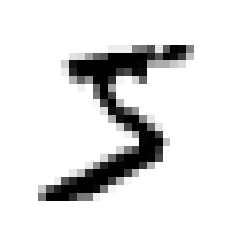

In [6]:
some_digit = X[0]
some_digit_image=np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y=y.astype(np.uint8)

** 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야한다.
MNIST 데이터셋은 이미 훈련세트와 테스트세트로 나누어 놓았다.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠지므로 데이터셋을 섞어 이런 문제를 방지해야함.
주의! 시계열 데이터를 다룰 때는 섞는 것이 좋지 않음.

##3.2 이진 분류기 훈련

이진 분류기: 두 개의 클래스를 구분할 수 있음

In [10]:
#타깃 벡터 만들기
y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)

In [11]:
#확률적 경사 하강법(SGD)분류기 사용
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

-> 분류기는 이 이미지가 5를 나타낸다고 추측하였음.

##3.3 성능 측정
###1) 3.3.1 교차 검증을 사용한 정확도 측정



> StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다. 



In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # error가 떠서 shuffle = True 설정

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


cross_Val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해보자.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3 , scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

-> 정확도가 95% 이상.

다음은 모든 이미지를 '5 아님 '클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype= bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

-> 90%이상 정확도가 나옴.

이는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌.
특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

###2) 3.3.2 오차 행렬
: 분류기의 성능을 평가하는 방법

오차행렬을 만들기 위해서는 실제 타깃과 비교할 수 있도록 예측값을 먼저 만들어야함.

테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됨!

* 테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용되는 것기 때문에!!!! 


In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

* cross_val_score() , cross_val_predict() 함수
k-겹 굧 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함.

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행 : 실제 클래스

오차 행렬의 열 : 예측한 클래스


In [20]:
#완벽한 분류기일 경우 주 대각선만 0이 아닌 값이 된다.
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])



### 3.3.3 정밀도와 재현율
정밀도 = TP / TP+FP

재현율 = TP / TP+FN

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

 F1 점수 : 정밀도와 재현율의 조화 평균 
 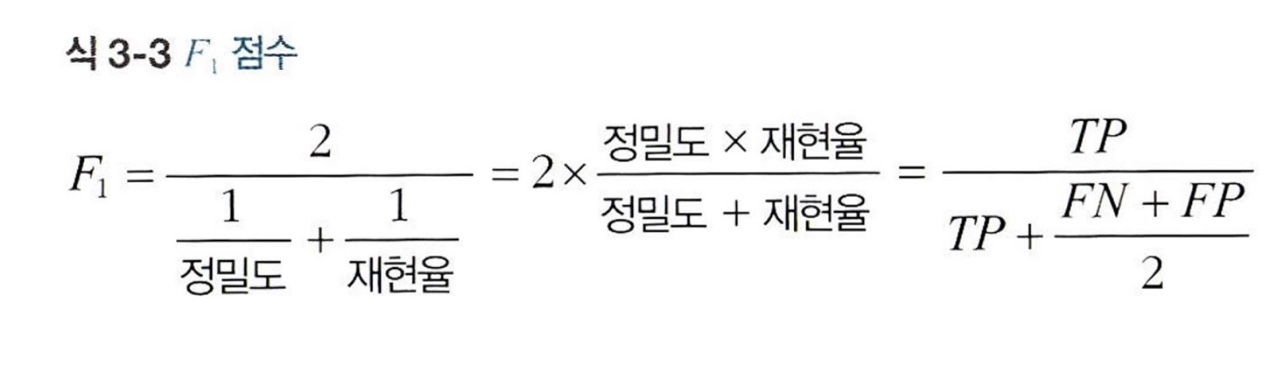

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/ 재현율 프레이드오프

SGDClassifier 분류 결정 과정

1. 결정함수를 사용하여 각 샘플의 점수 계산
2. 점수 > 임곗값 이라면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold=0
y_some_digit_pred = (y_scores> threshold)

SGDClassifier의 임곗값이 0이므로 위 코드는 predict()메서드와 같은 결과를 반환함

In [26]:
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

-> 이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌


In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 , method = "decision_function")

해당 점수로 precision_recall_curve()함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다. 

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


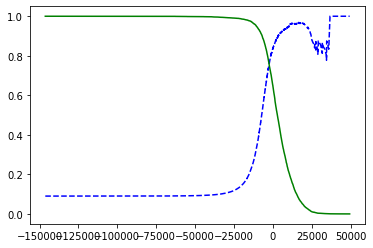

In [29]:
#맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

-> 재현율 80%근처에서 정밀도가 급격하게 줄어들기 때문에 이 하강점 직절을 정밀도/재현율 프레이드오프로 선택!



In [30]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90=(y_scores >= threshold_90_precision)

In [32]:
#정밀도
precision_score(y_train_5, y_train_pred_90)



0.9000345901072293

In [33]:
#재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

: 거짓 양성 비율에 대한 진짜 양성 비율의 곡선



In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

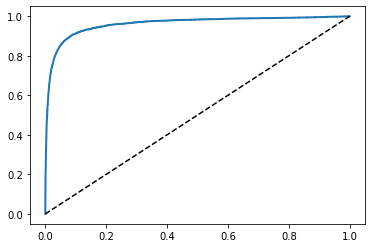

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  [...]

plot_roc_curve(fpr, tpr)
plt.show()

-> 재현율이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있다. 

- 곡선 아래의 면적(AUC)가 1인 경우 완벽한 분류기이고 완전한 랜덤 분류기는 0.5이다.

In [36]:
# roc의 auc를 계산하는 함수를 사이킷런에서 제공
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> ROC 곡선 : 거짓음성보다 거짓 양성이 더 중요할 때 정밀도/재현율 곡선보다 ROC를 사용함.



In [37]:
#랜덤포레스트 훈련 후 ROC AUC점수와 ROC곡선 비교

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPytho

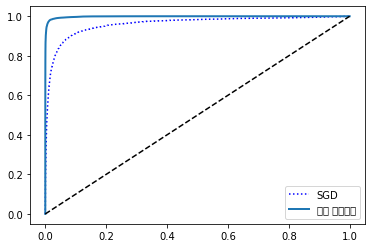

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

AUC 값이 큰 랜덤포레스트 분류기가 훨씬 좋다.

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류

이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기는 둘 이상의 클래스를 구별할 수 있음.

* (SGD분류기, 랜덤 포레스트 분류기, 나이브 베이즈) 일부 알고리즘은 여러개의 클래스를 직접 처리 할 수 있음
* (로지스틱 회귀나 서포트 벡터 머신 분류기)등 다른 알고리즘은 이진 분류만 가능

In [41]:
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train) #y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

-> 5를 구별한 타깃 클래스(y_train_5)대신 0에서 9까지의 원래 타깃클랫(y_train)를 사용해 SVC를 훈련시킨다. 

그런 다음 예측 하나를 만들어낸다.  내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각갂의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다. 

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

->샘플당 10개의 점수를 반환하는데 이 점수는 클래스마다 하나씩이다. 

In [43]:
np.argmax(some_digit_scores)


5

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5]

5

사이킷런에서 ovo나 ovr을 사용하도록 강제하려면 OneVsOneCassifier 나 OenVsRestClassifier를 사용한다.

In [46]:
#SVC기반으로 OvR전략을 사용하는 다중 분류기를 만드는 코드
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
#SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

위의 경우 SGD 분류기는 직접 새플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 ovo를 적용할 필요가 없다. 

In [49]:
#SGD분류기가 클래스마다 부여한 점수를 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
#분류기 평가 교차검증 사용
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
#스케일 조정하여 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석

가능성이 높은 모델을 하나 찾았다고 가정하고 모델의 성능을 향상 시킬 방법을 알아보자. 그 중 한가지 방법은 에러의 종류를 분석하는 것이다 

1) 오차 행렬 살펴보기

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

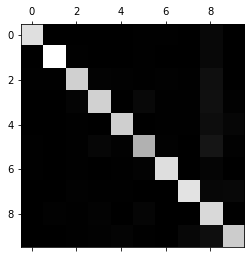

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

-> 이 오차행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보임. 

그래프의 에러 부분에 초점을 맞춰보자.
먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다. 

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

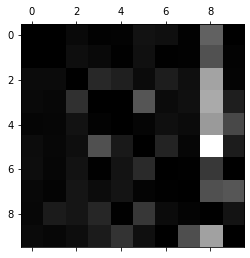

In [55]:
#다른 항목 유지, 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

-> 8의 열이 상당히 밝지만 8행은 밝지 않아서 실제 8이 8로 분류된 것은 맞음.

오차행렬은 반드시 대칭인 것은 아님. 

그치만 8열에 오류가 많아 보이기 때문에 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다는 판단이 섬. 

8처럼 보이는 숫자 훈련 데이터를 더 ㅁ낳이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다. 

In [ ]:
#3과 5의 샘플 
cl_a, cl_b= 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

-> 3과 5를 분류할 때 이미지의 위치나 회전 방향에 분류기가 매우 민감하게 반응 함. 따라서 3과 5의 에러를 줄이는 방법은 이미지를 ㅇ중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것이다. 

### 3.6 다중 레이블 분류

분류기가 샘플마다 여러개의 클래스를 출력해야하는 경우 = 여러 개의 이진 꼬리표를 출력하는 분류 시스템



In [63]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

-> 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel배열을 만듦

[
숫자가 큰 값인지 나타내고, 홀수인지 나타냄]

In [65]:
#F1점수 구하고 간단하게 평균 점수 계싼
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro") #지지도를 가중치로 두려면 average = "weighted" 로 설정

0.976410265560605

### 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것.

<이미지에서 잡음을 제거하는 시스템 만들기>

잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST이미지처럼 픽셀의 강도를 담은 배열로 출력. 

분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러개 가짐.


In [66]:
#MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint()함수를 사용하여 픽셀 강도에 잡음 추가
noise= np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

-> 분류기를 훈련시켜 이미지를 깨끗하게 만들었다. 